# Inference Notebook for VizWiz VQA

In [1]:
cd ..

/Users/zagaraa/Documents/GitHub/visionaid-vqa


/Users/zagaraa/Documents/GitHub/visionaid-vqa/vqa/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
ls

README.md         data/             notebooks/        scripts/
app.py            models/           outputs/          vqa/
app2.py           modules/          requirements.txt


# Custom Vision and Language Transformer (ViLT)

![img](/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg)

In [19]:
!python scripts/inference_robust_vilt.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg --question "What is in the image?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/vilt_finetuned_vizwiz2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Question: What is in the image?
Answer: beer


In [18]:
!python scripts/inference_robust_vilt.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000522.jpg --question "What brand is this beer?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/vilt_finetuned_vizwiz2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Question: What brand is this beer?
Answer: heineken


  0%|          | 0/10 [00:00<?, ?it/s]

Image: VizWiz_val_00000000.jpg
Question: Ok. There is another picture I hope it is a better one.
✅ True Label:      unanswerable
🤖 Predicted Label: yes
------------------------------------------------------------


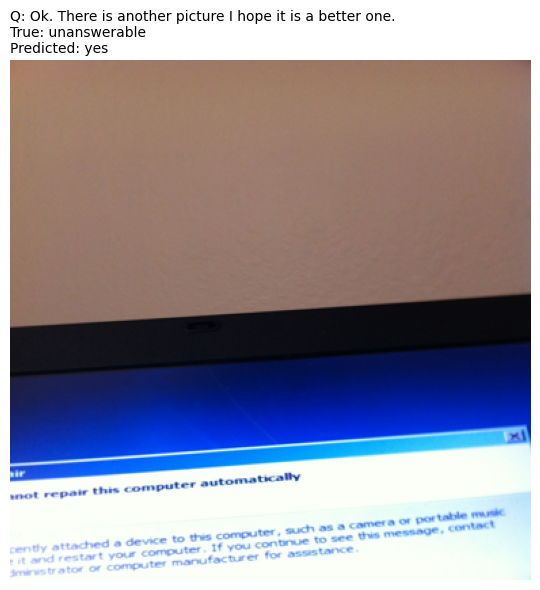

 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

Image: VizWiz_val_00000001.jpg
Question: Can you tell me what this medicine is please?
✅ True Label:      night time
🤖 Predicted Label: no
------------------------------------------------------------


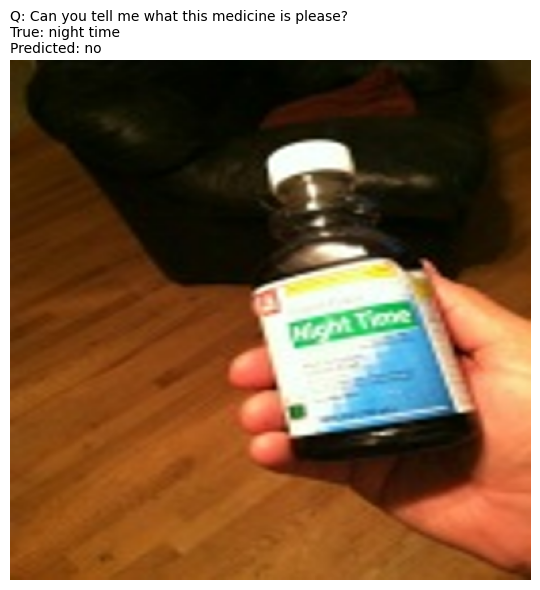

 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

Image: VizWiz_val_00000002.jpg
Question: What is the title of this book? 
✅ True Label:      dog years
🤖 Predicted Label: no
------------------------------------------------------------


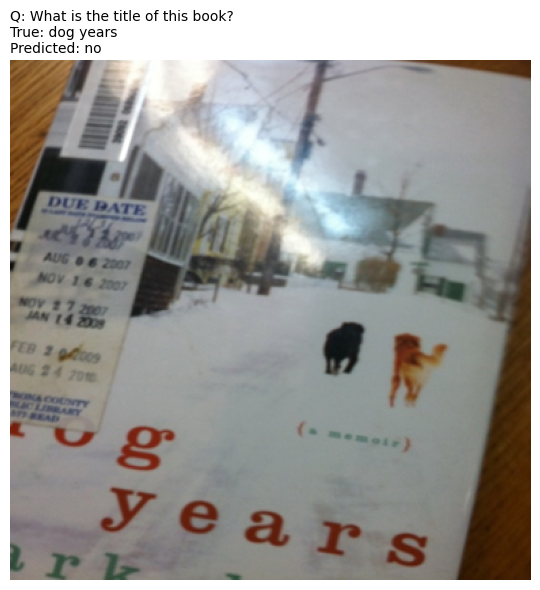

 30%|███       | 3/10 [00:02<00:05,  1.39it/s]

Image: VizWiz_val_00000003.jpg
Question: Which one is the blue one?
✅ True Label:      right
🤖 Predicted Label: left
------------------------------------------------------------


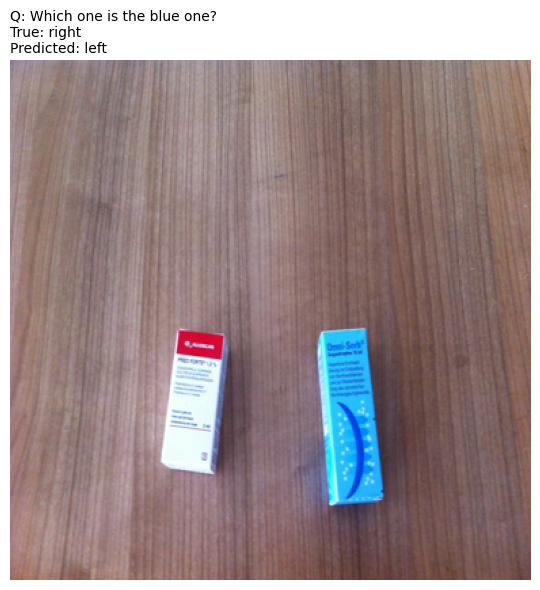

 40%|████      | 4/10 [00:03<00:04,  1.27it/s]

Image: VizWiz_val_00000004.jpg
Question: What does the arrow say?
✅ True Label:      unanswerable
🤖 Predicted Label: yes
------------------------------------------------------------


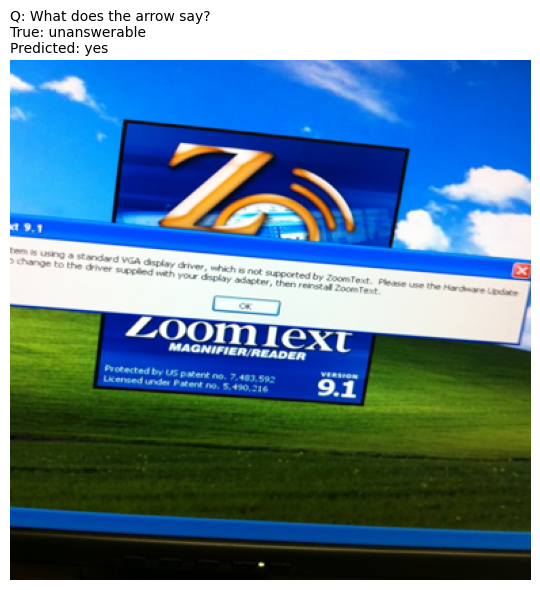

 50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

Image: VizWiz_val_00000005.jpg
Question: What the screen says? Thank you.
✅ True Label:      unanswerable
🤖 Predicted Label: windows
------------------------------------------------------------


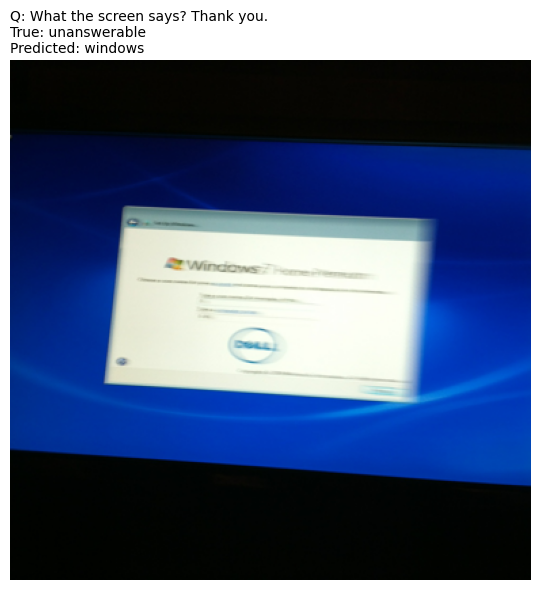

 60%|██████    | 6/10 [00:04<00:02,  1.45it/s]

Image: VizWiz_val_00000006.jpg
Question: What is seen on the laptop screen? What is seen on the laptop screen?
✅ True Label:      unanswerable
🤖 Predicted Label: nothing
------------------------------------------------------------


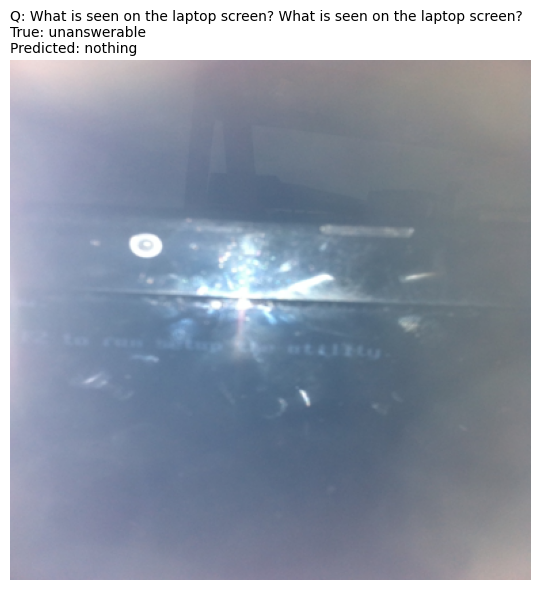

 70%|███████   | 7/10 [00:05<00:02,  1.46it/s]

Image: VizWiz_val_00000007.jpg
Question: Okay I think I got it this time. Can you read the model and serial number for me? Thanks.
✅ True Label:      unanswerable
🤖 Predicted Label: no
------------------------------------------------------------


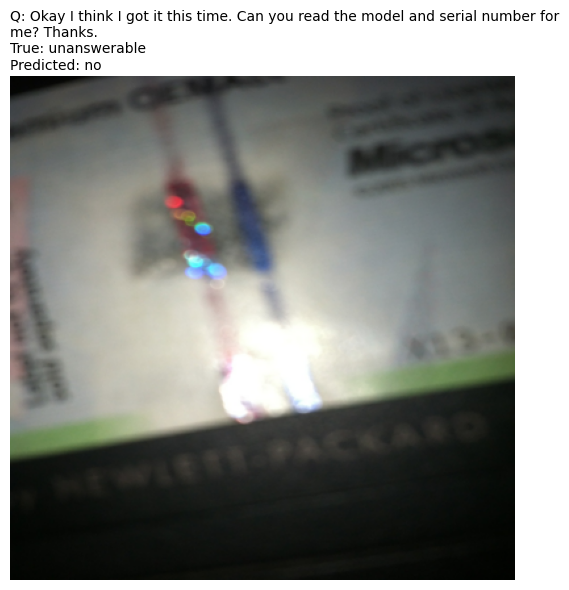

 80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

Image: VizWiz_val_00000008.jpg
Question: Is this shampoo or conditioner?
✅ True Label:      unanswerable
🤖 Predicted Label: shampoo
------------------------------------------------------------


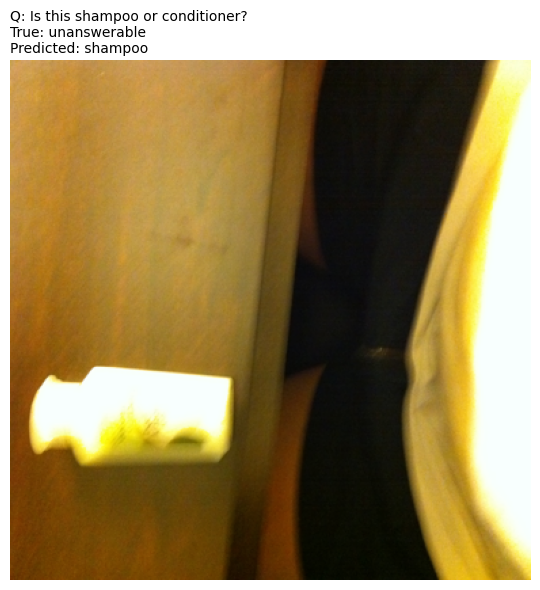

 90%|█████████ | 9/10 [00:06<00:00,  1.33it/s]

Image: VizWiz_val_00000009.jpg
Question: Can you describe for me what's going on outside the window? Just curious.
✅ True Label:      nothing
🤖 Predicted Label: nothing
------------------------------------------------------------


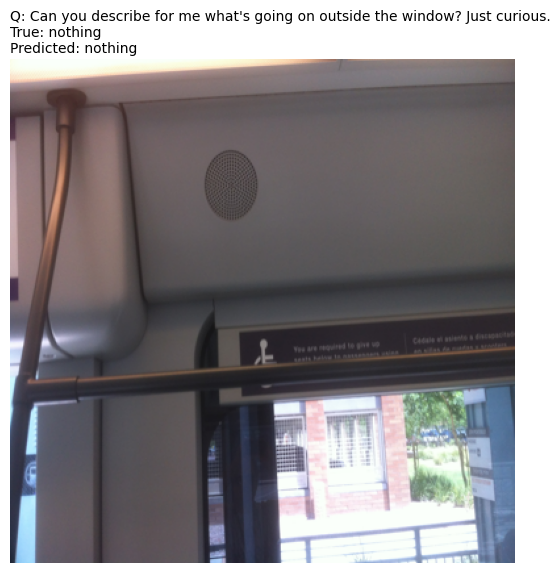

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


In [26]:
import os
import json
import torch
import numpy as np
from collections import Counter
from PIL import Image
from transformers import ViltProcessor, ViltForQuestionAnswering
from tqdm import tqdm
import matplotlib.pyplot as plt


# Set paths
model_path = "models/vilt_finetuned_vizwiz2"
val_images_dir = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/val/"
val_annotations_file = "/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/annotations/val.json"

# Load model and processor
processor = ViltProcessor.from_pretrained(model_path)
model = ViltForQuestionAnswering.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Load id2label and answer2id mapping
id2label = model.config.id2label
answer2id = {v.lower(): int(k) for k, v in id2label.items()}

# Load test annotations
with open(val_annotations_file, "r") as f:
    samples = json.load(f)

# Predict and print results
for sample in tqdm(samples[:10]):  # Adjust to all or a subset
    image_path = os.path.join(val_images_dir, sample["image"])
    image = Image.open(image_path).convert("RGB").resize((384, 384))
    question = sample["question"]

    # Prepare input
    inputs = processor(image, question, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_id = logits.argmax(-1).item()
        predicted_label = id2label.get(predicted_id, f"unknown_{predicted_id}").lower()


    # Ground truth (most common answer)
    answers = sample.get("answers", [])
    candidates = [a["answer"].strip().lower() for a in answers if a.get("answer", "").strip()]
    true_label = Counter(candidates).most_common(1)[0][0] if candidates else "unanswerable"

    print(f"Image: {sample['image']}")
    print(f"Question: {question}")
    print(f"✅ True Label:      {true_label}")
    print(f"🤖 Predicted Label: {predicted_label}")
    print("-" * 60)

# for sample in samples[:10]:  # Adjust range as needed
    image_path = os.path.join(val_images_dir, sample["image"])
    image = Image.open(image_path).convert("RGB").resize((384, 384))
    question = sample["question"]

    # Prepare input for ViLT
    inputs = processor(image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_id = logits.argmax(-1).item()
        predicted_label = id2label.get(predicted_id, f"unknown_{predicted_id}").lower()

    # Extract the ground truth answer
    answers = sample.get("answers", [])
    candidates = [a["answer"].strip().lower() for a in answers if a.get("answer", "").strip()]
    true_label = Counter(candidates).most_common(1)[0][0] if candidates else "unanswerable"

    # 🖼️ Display image + info
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(
        f"Q: {question}\n"
        f"True: {true_label}\n"
        f"Predicted: {predicted_label}",
        fontsize=10,
        loc='left',
        wrap=True
    )
    plt.tight_layout()
    plt.show()

# BLIP2

![img](/Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000299.jpg)

In [8]:
!python scripts/inference_blip2.py --image /Users/zagaraa/Documents/GitHub/visionaid-vqa/data/vizwiz/test/VizWiz_test_00000299.jpg --question "What is this product?" --model_path /Users/zagaraa/Documents/GitHub/visionaid-vqa/models/local_blip2/

Loading checkpoint shards: 100%|██████████████████| 4/4 [00:02<00:00,  1.38it/s]
Question: What is this product?
Answer: niacin
